
# Projeto Nadir
Início do desenvolvimento do meu projeto de conclusão de curso que será chamado de projeto Nadir.<br>
Os objetivos que quero atingir são:


1.   Criar uma Rede Neural capaz de classificar imagens de constelações
2.   Criar uma Rede Neural capaz de classificar dentro de uma imagem do céu a localização e classificação de diversas constelações
3.   Criar uma Rede Neural capaz de segmentar a imagem e mostrar as constelações indicando os pontos das estrelas e os trações que formam os desenhos da constelações

Inicialmente, trabalharei com apenas 4 constelações:
1. Órion
2. Cruzeiro do Sul
3. Cão Maior
4. Ursa Menor

Tentarei alcançar os objetivos na ordem que foram descritos acima. Caso obtenha bons resultados, tentarei expandir o número de constelações.

Inicialmente, a fim de ver de ter um benchmark para o pré-processamento, farei os primeiros testes sem pré-processar as imagens do dataset.




In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
import os
import imutils
from imutils import paths
from keras.models import Sequential, Model, Input
from keras.layers import Dense, Flatten, Dropout, Activation, Conv2D, MaxPooling2D, AveragePooling2D
from keras.preprocessing.image import ImageDataGenerator, img_to_array, array_to_img
from keras.applications import VGG16
from keras.applications.vgg16 import preprocess_input,decode_predictions
from keras.optimizers import Adam
from keras.utils import np_utils
from sklearn.preprocessing import LabelBinarizer, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

Using TensorFlow backend.


In [ ]:
#from google.colab import drive
#drive.mount('/content/drive')

#workdir_path = '/content/drive/My Drive/Colab Notebooks/TCC' #MODIFICAR!!! #Caminho para o seu workspace
#os.chdir(workdir_path)

In [ ]:
#!ls

In [6]:
train = 'dataset/train/'
test = 'dataset/test/'

Lendo as labels existentes e registrando

In [5]:
labels = os.listdir(train)

In [7]:
#Teste de código
labels[0]

'canis major'

In [8]:
#Teste de código
for label in labels:
  print(label)
  print(os.listdir(train + label))

canis major
['1.jpg', '2.jpg', '3.jpg']
crux
['1.jpg', '2.jpg', '3.jpg', '4.jpg', '5.jpg']
orion
['1.jpg', '2.jpg', '3.jpg', '4.jpg', '5.jpg']
ursa minor
['1.jpg', '2.jpg', '3.jpg', '4.jpg']


In [9]:
#Teste de código
os.listdir(train +  labels[0])
list(paths.list_images(train +  labels[0]))

['dataset/train/canis major\\1.jpg',
 'dataset/train/canis major\\2.jpg',
 'dataset/train/canis major\\3.jpg']

Lendo os dados de treino e de teste e armazenando nas respectivas variáveis

In [10]:
#Lendo os dados de treino
x_train = []
y_train = []
for label in labels:

  caminhos = list(paths.list_images(train +  label))

  for caminho in caminhos:
    image = cv2.imread(caminho)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = cv2.resize(image, (224, 224))

    y_train.append(label)
    x_train.append(image)

In [11]:
#Lendo os dados de teste
x_test = []
y_test = []
for label in labels:

  caminhos = list(paths.list_images(test +  label))

  for caminho in caminhos:
    image = cv2.imread(caminho)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = cv2.resize(image, (224, 224))

    y_test.append(label)
    x_test.append(image)

Convertantendo para os formatos necessários

In [12]:
x_train, y_train, x_test, y_test = np.array(x_train)/255.0, np.array(y_train), np.array(x_test)/255.0, np.array(y_test) 

canis major
--------------------------


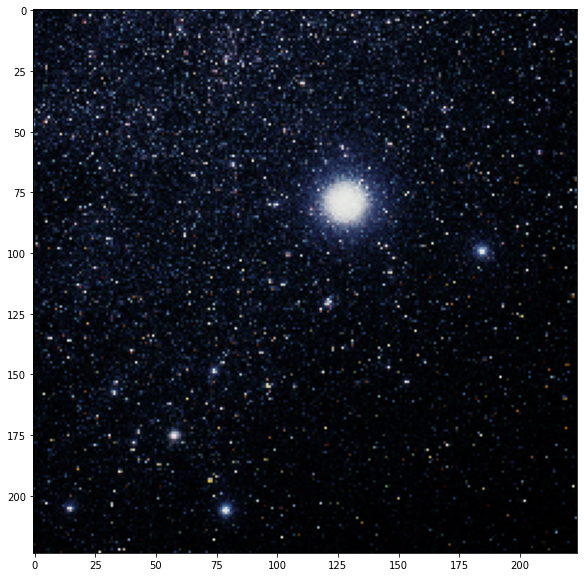

In [13]:
#Checando se está tudo certo
print(y_train[0])
plt.figure(figsize=(10,10))
plt.imshow(x_train[0]);
print('--------------------------')

orion
--------------------------


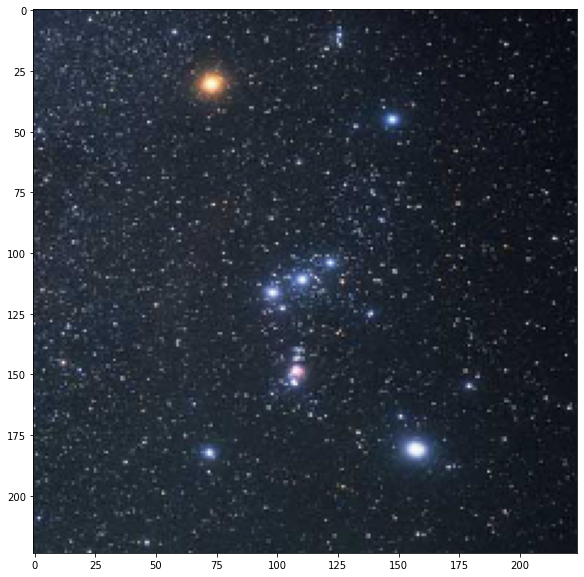

In [14]:
print(y_test[5])
plt.figure(figsize=(10,10))
plt.imshow(x_test[5]);
print('--------------------------')

Gerando o geradores de Data Augmentation. Estava dando algum erro que eu não identifiquei ainda. A imagem gerada ficava toda preta. Agora está funcionando, mas tomar cuidado pra ver se sempre está funcionando.

In [15]:
#Data Augmentation
trainDataGen = ImageDataGenerator(
 rotation_range=30, zoom_range=0.2, width_shift_range=0.2
)

testDataGen = ImageDataGenerator(
 rotation_range=30, zoom_range=0.2, width_shift_range=0.2
)

In [16]:
#trainDataGen.fit(x_train)
#testDataGen.fit(x_test)

In [17]:
batch_size = 16

train_generator = trainDataGen.flow(x_train, np.array(pd.get_dummies(y_train)), 
                                     batch_size=batch_size, 
                                     shuffle=True)

test_generator = testDataGen.flow(x_test, np.array(pd.get_dummies(y_test)), 
                                     batch_size=batch_size, 
                                    shuffle=True)

In [18]:
#Apenas um teste para ter certeza que o Data Augmentation funcionou
#i = 0
#for X_batch, y_batch in train_generator:
#  while i < 9:
#    plt.subplot(330+1+i)
#    plt.imshow(X_batch[i], cmap=plt.get_cmap('gray'))
#    i += 1
#    if i >= 9:  break
#  plt.show()

Os generators vão retornar uma tupla: CORRIGIR
1. A primeira será a imagem em si. O valor de X
2. A segunda será o label relativo. O valor de y

In [19]:
train_generator.__next__()[1].shape

(16, 4)

In [20]:
#print(train_generator.__next__()[1][1])
#plt.imshow(train_generator.__next__()[0][1]);

Abordagem fazendo a rede toda junta

In [21]:
model_vgg = VGG16(include_top=False, weights='imagenet', input_shape=(224, 224, 3))
model_vgg.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [22]:
INIT_LR = 1e-3
EPOCHS = 25 # PODE MUDAR
BS = 32

In [23]:
headmodel = model_vgg.output
headmodel = Flatten(name="flatten")(headmodel)
headmodel = Dense(128, activation='relu')(headmodel)
headmodel = Dropout(0.5)(headmodel)
headmodel = Dense(64, activation='relu')(headmodel)
headmodel = Dropout(0.5)(headmodel)
headmodel = Dense(4, activation='softmax')(headmodel)

model = Model(inputs = model_vgg.input, outputs = headmodel, name='Nadir')

for layer in model_vgg.layers:
  layer.trainable = False

opt = Adam(learning_rate=INIT_LR, decay=INIT_LR/EPOCHS)

model.compile(loss = "categorical_crossentropy", optimizer = opt, metrics=['accuracy'])

In [27]:
 import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUs Available:  0


In [24]:
model.summary()

Model: "Nadir"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [25]:
x_train.shape

(17, 224, 224, 3)

In [26]:
h = model.fit_generator(
    train_generator,
    steps_per_epoch = 10,
    validation_data = train_generator,
    validation_steps = 5,
    epochs = 50
)

Epoch 1/50
10/10 [==============================] - 30s 3s/step - loss: 2.9392 - accuracy: 0.2000 - val_loss: 2.4587 - val_accuracy: 0.2800
Epoch 2/50
10/10 [==============================] - 25s 3s/step - loss: 4.5743 - accuracy: 0.3529 - val_loss: 3.2402 - val_accuracy: 0.5429
Epoch 3/50
10/10 [==============================] - 31s 3s/step - loss: 4.8226 - accuracy: 0.2588 - val_loss: 1.0951 - val_accuracy: 0.4800
Epoch 4/50
10/10 [==============================] - 26s 3s/step - loss: 3.5973 - accuracy: 0.3059 - val_loss: 0.1046 - val_accuracy: 0.5143
Epoch 5/50
10/10 [==============================] - 29s 3s/step - loss: 1.7508 - accuracy: 0.4471 - val_loss: 0.7440 - val_accuracy: 0.7200
Epoch 6/50
10/10 [==============================] - 26s 3s/step - loss: 1.4993 - accuracy: 0.4471 - val_loss: 1.2815 - val_accuracy: 0.7429
Epoch 7/50
10/10 [==============================] - 30s 3s/step - loss: 1.5410 - accuracy: 0.3765 - val_loss: 0.8935 - val_accuracy: 0.5400
Epoch 8/50
10/10 [==

KeyboardInterrupt: 

In [ ]:
df_history = pd.DataFrame(h.history)

fig = plt.figure();
ax = df_history[['val_loss', 'loss']].plot(figsize=(10, 5));

In [ ]:
fig = plt.figure();
ax = df_history[['val_accuracy', 'accuracy']].plot(figsize=(10, 5));

In [ ]:
df_history.head()

In [ ]:
dicionario = {
    0: 'canis major',
    1: 'crux',
    2: 'orion',
    3: 'ursa minor'
}

In [ ]:
test_images = []
test_labels = []
for i in range(20):
  x,y = next(test_generator)
  test_images.append(x)
  test_labels.append(y)

In [ ]:
plt.imshow(np.array(test_images)[19][2])

In [ ]:
test_labels[3][2]

In [ ]:
zxc = model.predict(np.array(test_images).reshape(200, 224,224,3))

In [ ]:
plt.imshow(np.array(test_images).reshape(200, 224,224,3)[72])

In [ ]:
np.argmax(zxc[72])

In [ ]:
for i in pd.DataFrame(range(200)).sample(9).values:
  plt.subplot(330+1+i)
  plt.imshow(np.array(test_images).reshape(200, 224,224,3)[72])

In [ ]:
pd.DataFrame(range(200)).sample(9).values